<a href="https://www.kaggle.com/code/pedrobarrios/proyecto1-convolutional-kuzushijimnist?scriptVersionId=98285413" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Cargando librerias a usar
import torch
import torchvision
from torchvision import transforms, datasets

import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import helper

print("[INFO] Librerias cargadas")

[INFO] Librerias cargadas


Carga de datos del dataset de Kuzushiji-MNIST de Anokas

In [2]:
#Funcion de apoyo para adaptar la forma del dataset
def resize(data):
    data = data.reshape(data.shape[0], 1, data.shape[1], data.shape[2])
    return data

print("[INFO] loading the KMNIST dataset...")
#Carga del dataset a arrays auxiliares
arr_train_img = np.load("../input/kuzushiji/kmnist-train-imgs.npz")['arr_0']
arr_train_label = np.load("../input/kuzushiji/kmnist-train-labels.npz")['arr_0']
arr_test_img = np.load("../input/kuzushiji/kmnist-test-imgs.npz")['arr_0']
arr_test_label = np.load("../input/kuzushiji/kmnist-test-labels.npz")['arr_0']

#Pasandolos a Tensor de pytorch
train_images = torch.Tensor(arr_train_img)/255
train_labels = torch.Tensor(arr_train_label).type(torch.LongTensor)
test_images = torch.Tensor(arr_test_img)/255
test_labels = torch.Tensor(arr_test_label).type(torch.LongTensor)

#Cambiando la forma del Tensor de las imagenes
train_images,test_images = resize(train_images),resize(test_images)

print("[INFO] KMNIST dataset 50% loaded")

[INFO] loading the KMNIST dataset...
[INFO] KMNIST dataset 50% loaded


In [ ]:
#Verificando forma de la data importada y transformada
print("Imagenes")
print(train_images.shape)
print(test_images.shape)
print("Labels")
print(train_labels.shape)
print(test_labels.shape)

Clases, hiperparametros y Dataloader de pytorch estableciendo set de entrenamiento y set de pruebas

In [3]:
#HIPERPARAMETROS Y DEMAS

# Creando las clases para los diferentes familias de caracteres a clasificar
classes = ('O', 'Ki', 'Su', 'Tsu'
           , 'Na', 'Ha', 'Ma', 'Ya'
           , 'Re', 'Wo')

# Definimos el tamaños de los batch, los Epoch y el rate de aprendizaje
batch_size = 32
learning_rate = 0.01
epochs = 20
softmax_classes = 10

#Conversion de Tensor a Dataset de pytorch
trainset = torch.utils.data.TensorDataset(train_images,train_labels)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)

testset = torch.utils.data.TensorDataset(test_images,test_labels)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

print("[INFO] KMNIST dataset loaded")

[INFO] KMNIST dataset loaded


MODELOS DE REDES NEURONALES

In [ ]:
# Arquitectura V1
class ConvNN(nn.Module):
    def __init__(self, softmax_classes):
        super(ConvNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(5408, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, softmax_classes)
    
    # Progresses data across layers    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.max_pool1(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = F.log_softmax(out,dim=1)
        return out
    
print("[INFO] Arquitectura V1 utilizada")

In [7]:
# Arquitectura V2
class ConvNN(nn.Module):
    def __init__(self, softmax_classes):
        super(ConvNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(1600, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, softmax_classes)
    
    # Progresses data across layers    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.max_pool1(out)
        
        out = self.conv_layer2(out)
        out = self.max_pool2(out)
                
        out = torch.flatten(out,1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = F.log_softmax(out,dim=1)
        return out
    
print("[INFO] Arquitectura V2 utilizada")

[INFO] Arquitectura V2 utilizada


In [8]:
# Declaramos la red
model = ConvNN(softmax_classes)

# Definimos la metrica de la funcion de perdida
criterion = nn.CrossEntropyLoss()

# Seleccionamos nuestro optimizador
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("[INFO] Modelo, funcion de perdida y optimizador declarados")

[INFO] Modelo, funcion de perdida y optimizador declarados


In [37]:
print("[INFO] Iniciando entrenamiento del modelo")
#Entrenamiento
model.train()
for e in range(epochs):
    trainLoss  = 0
    accuracy  = 0
    for (images, labels) in trainloader:
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        trainLoss += loss.item()
        _, predicted = torch.max(nn.functional.softmax(outputs, dim=1), 1)
        accuracy += (predicted == labels).sum()
        
    else:
        trainLoss = trainLoss/len(trainloader)
        accuracy = 100 * accuracy.numpy()/len(train_images)
        
        print('Epoch:{} \t Training Loss:{:.6f} \t Training Acc:{:.2f}'.format(
            e+1, 
            trainLoss,
            accuracy
        ))
        
print("[INFO] Entrenamiento del modelo finalizado")

[INFO] Iniciando entrenamiento del modelo
Epoch:1 	 Training Loss:0.009361 	 Training Acc:99.89
Epoch:2 	 Training Loss:0.008195 	 Training Acc:99.90166666666667


KeyboardInterrupt: 

CODIGO PARA CALCULAR PRECISION CON EL SET DE PRUEBA

In [35]:
model.eval()
with torch.no_grad():
    accuracy = 0
    test_loss = 0
    acc_avg = []
    testloss_avg = []
    for images, labels in testloader:
        output = model(images)
        loss = criterion(output, labels)
        test_loss = loss.item()/len(testloader)
        _, predicted = torch.max(nn.functional.softmax(output, dim=1), 1)
        accuracy += (predicted == labels).sum().item()
        accuracyf = (100*accuracy)/labels.size(0)
        acc_avg.append(accuracyf)
        testloss_avg.append(test_loss)
        accuracy,accuracyf = 0,0
    print(f'Test Accuracy: {np.mean(acc_avg):.2f}%')
    print(f'Test Loss: {np.mean(testloss_avg):.4f}%')
    

Test Accuracy: 93.20%
Test Loss: 0.0010%


Clase predecida = Ya
Clase correcta = Ya


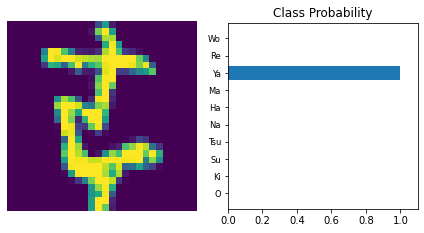

In [52]:
import matplotlib.pyplot as plt

def view_classify(img, ps):
    ps = ps.data.numpy().squeeze()
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(classes, size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
    
model.eval()
images, labels = next(iter(testloader))

with torch.no_grad():
    logps = model(images)
ps = torch.exp(logps[0])

probab = list(ps.numpy())
print("Clase predecida =", classes[probab.index(max(probab))])
print("Clase correcta =", classes[labels[0]])

view_classify(img.resize_(1, 28, 28), ps)